# Combustion Chemistry in Isobaric Reactor: Generatign Training Database in the Original State Space

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE    
# from PCAfold         import PCA          as PCAA

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
OutputDir    = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_10Cases_H2_Iter_LOG/')
FigDir       = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet/')


tStratch     = 1.
SOLVER       = 'BDF'

valid_perc   = 20.

FixedMinVal  = 1.e-14


ColorVec     = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

## Reading Data

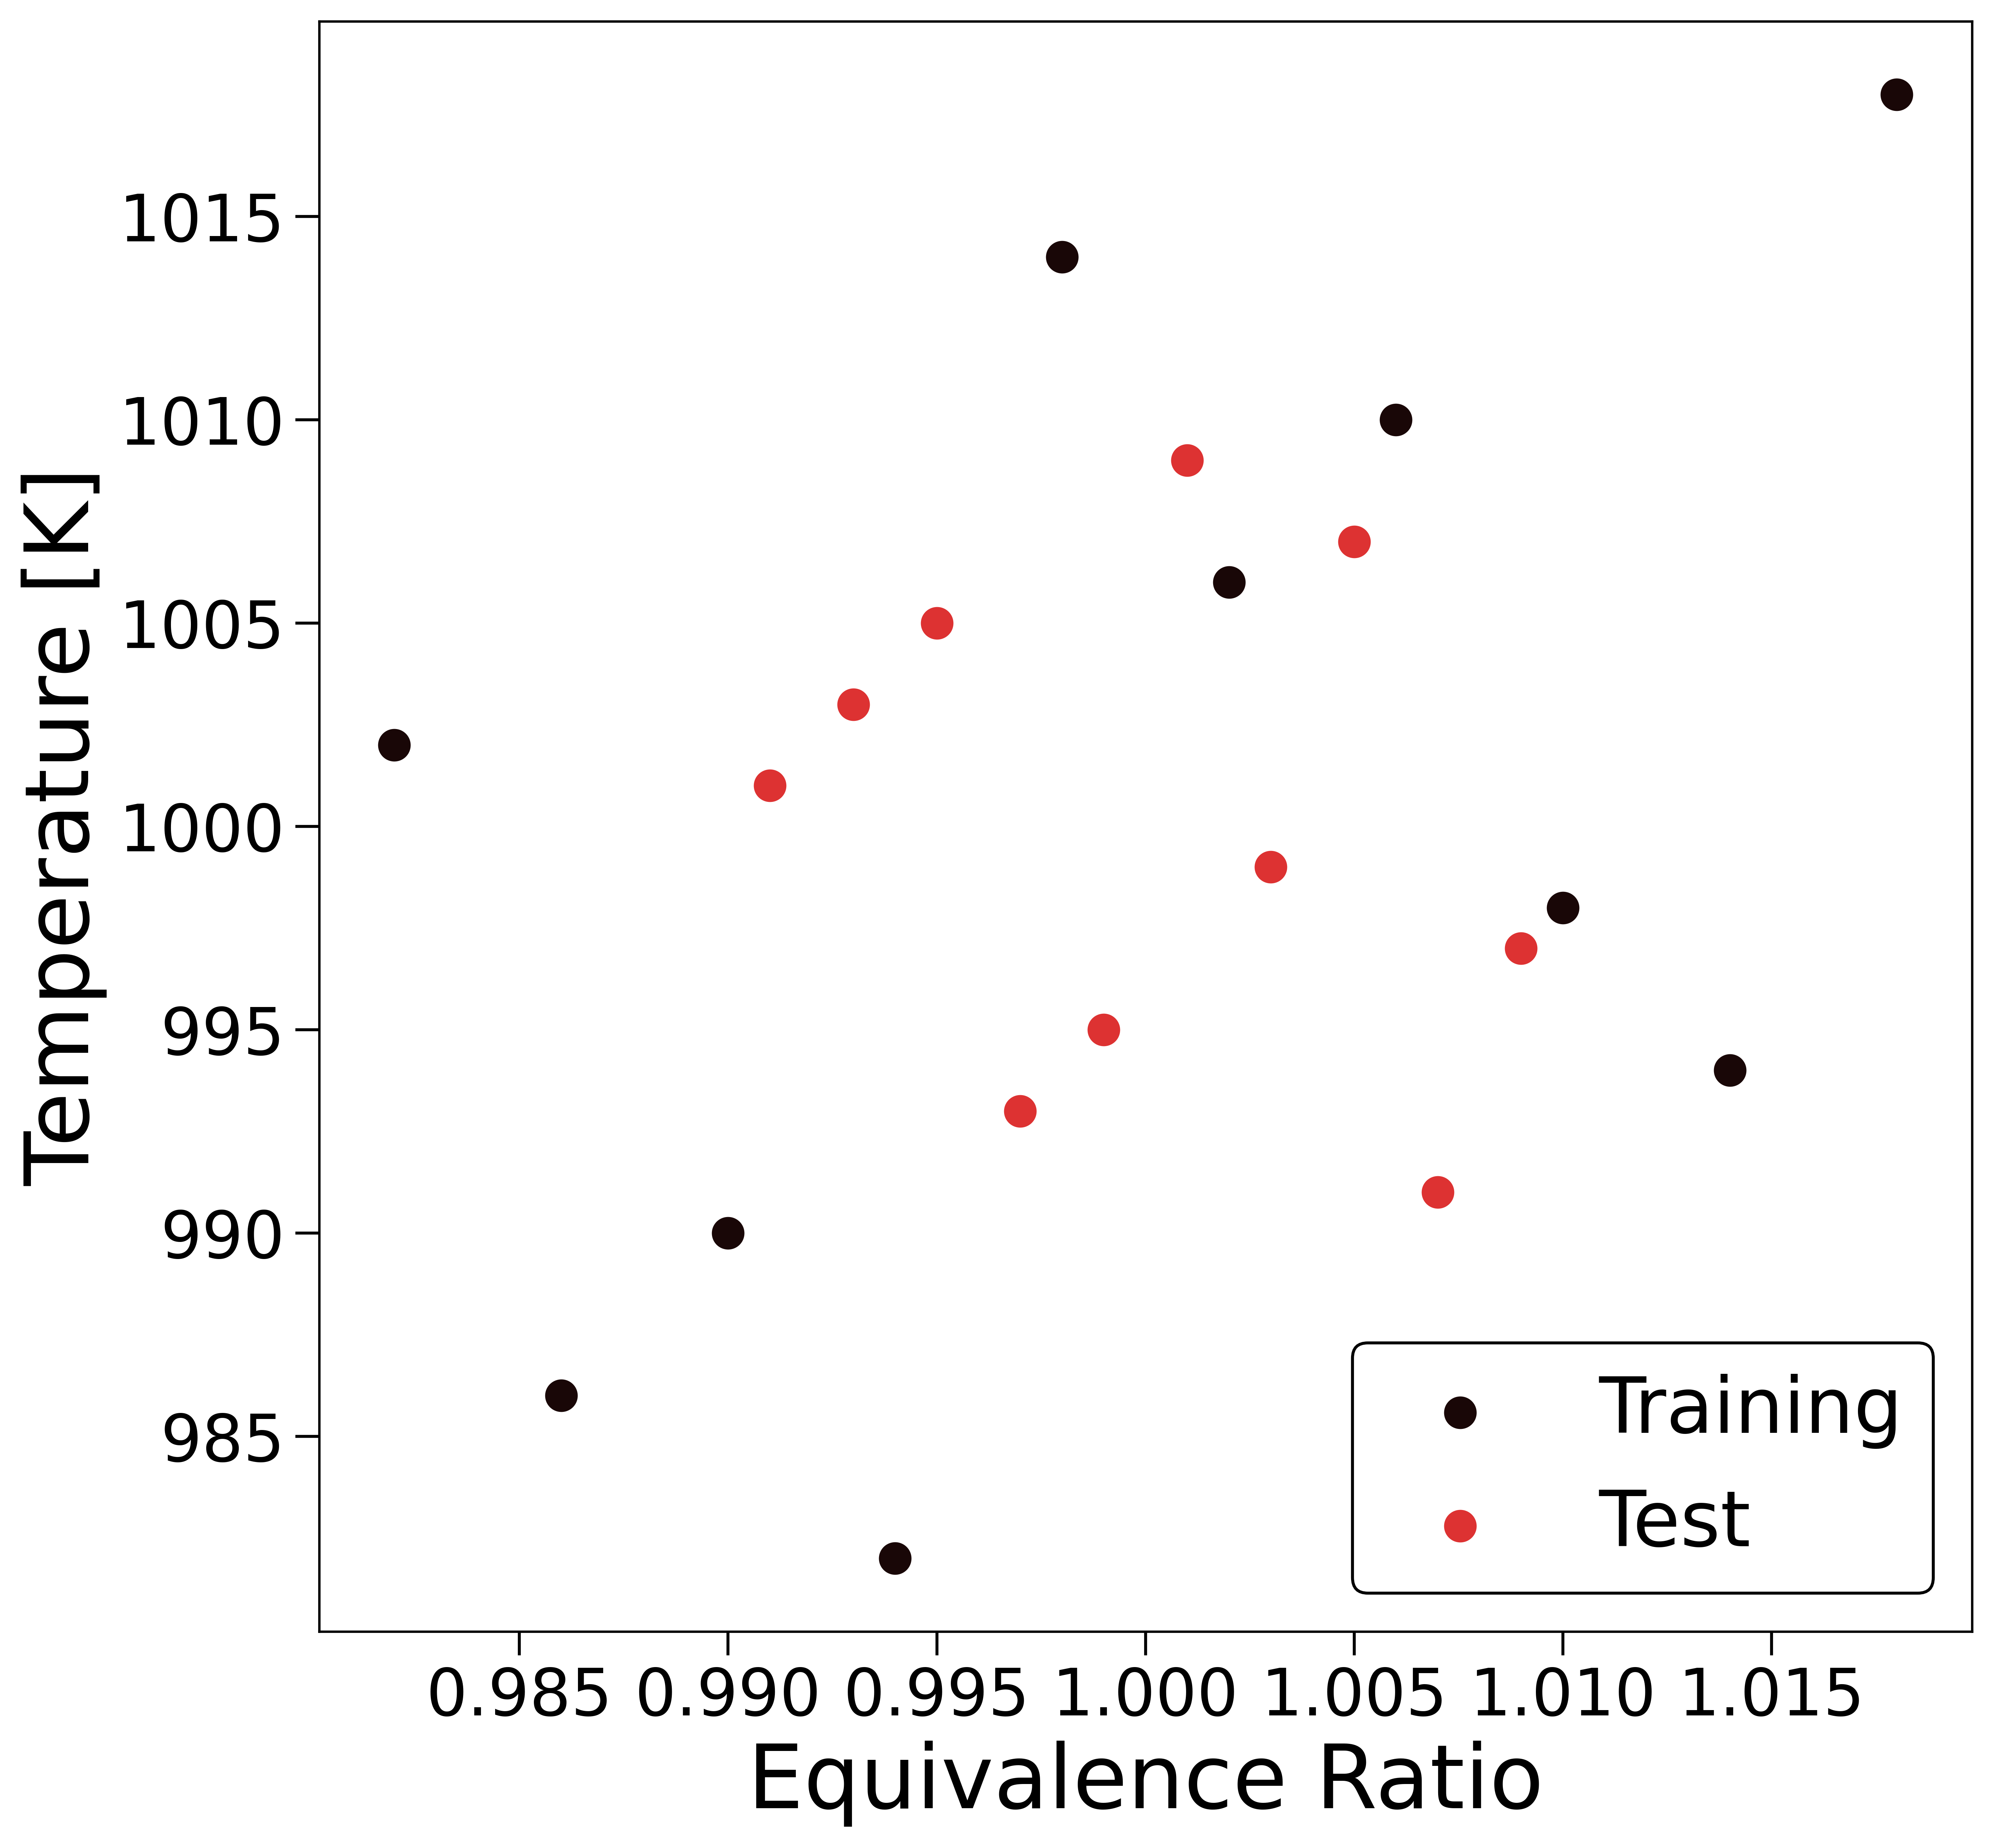

In [3]:
FileName = os.path.join(OutputDir, 'Orig/train/ext/CleanVars.csv')
Vars     = pd.read_csv(FileName, header=None)
Vars     = list(Vars.to_numpy()[0,:])
Vars0    = [Vars[i]+'0' for i in range(len(Vars))]
Var0Dic  = {}
for Var in Vars:
    Var0Dic[Var] = Var+'0'
InputVar     = ['t'] + Vars0


    
FileName     = os.path.join(OutputDir, 'Orig/train/ext/SimIdxs.csv')
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)

FileName     = os.path.join(OutputDir, 'Orig/train/ext/ICs.csv')
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics        = len(ICVecs)

P0Vec        = []
EqRatio0Vec  = []
T0Vec        = []
for iC in range(n_ics):
    Nts      = SimIdxs[iC,1]-SimIdxs[iC,0]
    P0Vec.append(       np.ones(1, dtype=np.float64)*ICVecs[iC,0])
    EqRatio0Vec.append( np.ones(1, dtype=np.float64)*ICVecs[iC,1])
    T0Vec.append(       np.ones(1, dtype=np.float64)*ICVecs[iC,2])
P0Vec        = np.concatenate(P0Vec)[...,np.newaxis]
EqRatio0Vec  = np.concatenate(EqRatio0Vec)[...,np.newaxis]
T0Vec        = np.concatenate(T0Vec)[...,np.newaxis]


FileName     = os.path.join(OutputDir, 'Orig/test/ext/SimIdxs.csv')
Data         = pd.read_csv(FileName, header=0)
SimIdxsTest  = Data.to_numpy(int)

FileName     = os.path.join(OutputDir, 'Orig/test/ext/ICs.csv')
Data         = pd.read_csv(FileName)
ICVecsTest   = Data.to_numpy()
n_ics_test   = len(ICVecsTest)

P0VecTest       = []
EqRatio0VecTest = []
T0VecTest       = []
for iC in range(n_ics_test):
    NtsTest      = SimIdxsTest[iC,1]-SimIdxsTest[iC,0]
    P0VecTest.append(       np.ones(1, dtype=np.float64)*ICVecsTest[iC,0])
    EqRatio0VecTest.append( np.ones(1, dtype=np.float64)*ICVecsTest[iC,1])
    T0VecTest.append(       np.ones(1, dtype=np.float64)*ICVecsTest[iC,2])
P0VecTest        = np.concatenate(P0VecTest)[...,np.newaxis]
EqRatio0VecTest  = np.concatenate(EqRatio0VecTest)[...,np.newaxis]
T0VecTest        = np.concatenate(T0VecTest)[...,np.newaxis]


fig = plt.figure()
plt.scatter(EqRatio0Vec,     T0Vec,                    label='Training')
plt.scatter(EqRatio0VecTest, T0VecTest, c=ColorVec[1], label='Test')
plt.xlabel('Equivalence Ratio')
plt.ylabel('Temperature [K]')
plt.legend(loc=4)

if (FigDir):
    plt.savefig(FigDir+'/0DReact_ICs.eps', format='eps', bbox_inches='tight')

In [4]:
for iC in range(n_ics):
    FileName         = OutputDir+'/Orig/train/ext/y.csv.'+str(iC+1)
    DataNew          = pd.read_csv(FileName, header=0)
    Nts              = len(DataNew)
    DFa = DataNew.iloc[range(1,len(DataNew))]['t'].reset_index(drop=True) - DataNew.iloc[range(0,len(DataNew)-1)]['t'].reset_index(drop=True)
    DFb = DataNew.iloc[range(0,len(DataNew)-1)][Vars].reset_index(drop=True)
    DFc = DataNew.iloc[range(1,len(DataNew))][Vars].reset_index(drop=True)
    DFb = np.log10( DataNew.iloc[range(0,len(DataNew)-1)][Vars].reset_index(drop=True) + 1.e-14)
    DFc = np.log10( DataNew.iloc[range(1,len(DataNew))][Vars].reset_index(drop=True) + 1.e-14)
    DataAll         = pd.concat( [DFa, DFb, DFc], axis=1, ignore_index=True )
    DataAll.columns = ['t'] + Vars0 + Vars
    if (iC==0):
        Data         = DataAll
    else:
        Data         = pd.concat([Data, DataAll], axis=0)
Data.reset_index(drop=True, inplace=True)

## Splitting Data and Writing Database 

In [5]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/Orig/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/')
except:
    pass

In [6]:
data_id    = 'pts'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/Orig/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[InputVar]
DataInput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t'] + Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Output.csv', index=False)

In [7]:
data_id    = 'res'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/Orig/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[InputVar]
DataInput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Input.csv', index=False)

DataOutput       = DataNoZero[['t'] + Vars]
DataOutput[Vars] = DataOutput[Vars].to_numpy() * 0.
DataOutput.iloc[train_idx].to_csv(OutputDir+'/Orig/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Output.csv', index=False)

/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_66846/3647220390.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataOutput[Vars] = DataOutput[Vars].to_numpy() * 0.


In [8]:
data_id = 'ics'

Data_ics                     = Data[Data['t'] == FixedMinVal]
n_points_ics                 = len(Data_ics)

idx_ics                      = np.arange(n_points_ics)
train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=valid_perc/100, random_state=41)

n_valid                      = len(valid_idx)
n_train                      = len(train_idx)

try:
    os.makedirs(OutputDir+'/Orig/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/Orig/valid/'+data_id+'/')
except:
    pass

DataInput  = Data_ics[InputVar]
DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/Orig/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Input.csv', index=False)

DataOutput = Data_ics[['t'] + Vars]
DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/Orig/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/Orig/valid/'+data_id+'/Output.csv', index=False)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# data_id = 'scs'

# Mask                         = [i for i in range(1,len(Data)-1) if Data.iloc[i-51]['t'] == FixedMinVal]
# Data_ics                     = Data.iloc[Mask]
# n_points_ics                 = len(Data_ics)
# idx_ics                      = np.arange(n_points_ics)
# train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=valid_perc/100, random_state=41)

# try:
#     os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
# except:
#     pass
# try:
#     os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
# except:
#     pass

# DataInput      = Data_ics[InputVar]
# DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
# DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

# DataOutput     = Data_ics[['t'] + Vars]
# DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
# DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [ ]:
# data_id = 'fcs'

# Mask                         = [i for i in range(-1,len(Data)-1) if Data.iloc[i+1]['t'] == FixedMinVal]
# Data_ics                     = Data.iloc[Mask]

# n_points_ics                 = len(Data_ics)
# idx_ics                      = np.arange(n_points_ics)
# train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=valid_perc/100, random_state=43)

# try:
#     os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
# except:
#     pass
# try:
#     os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
# except:
#     pass

# DataInput      = Data_ics[InputVar]
# DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
# DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

# DataOutput       = Data_ics[['t'] + Vars]
# DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
# DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)